In [1]:
# Import tensorflow and additional libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.keras.backend.clear_session()

# Check version
print('tensorflow version: ', tf.__version__)

tensorflow version:  2.6.2


In [2]:
# Load : Fashion MNIST Dataest
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

size_of_train  = len(x_train)
size_of_test  = len(x_test)
num_of_class = 10

print('The Shape of dataset:', x_train[0].shape)
print('The number of train image:', size_of_train)
print('The number of test image:', size_of_test)

The Shape of dataset: (28, 28)
The number of train image: 60000
The number of test image: 10000


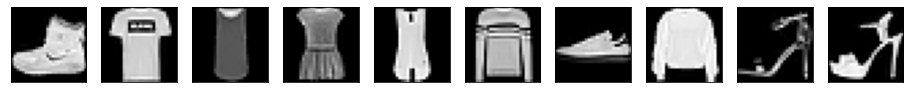

In [3]:
# Train Data
plt.figure(figsize=(16, 10))
for i in range(num_of_class):
    ax = plt.subplot(1, num_of_class, i+1)
    plt.imshow(x_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [4]:
print('== Before normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

## Dataset Pre-processing ##
# Normalization
x_train = x_train/255.  
x_test = x_test/255. 

# Reshape(Adding channel)
x_train = x_train.reshape((size_of_train, 28, 28, 1))
x_test = x_test.reshape((size_of_test, 28, 28, 1))

print('\n== After normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

== Before normalization ==
Image Shape: (28, 28)
Value MIN: 0, MEAN:97.25, MAX:255

== After normalization ==
Image Shape: (28, 28, 1)
Value MIN: 0, MEAN:0.38, MAX:1


In [5]:
def channel_attention(x, scale_factor=4):
    ####Fill your code####
    attn_x = tf.keras.layers.GlobalAveragePooling2D()(x)
    num_channel = attn_x.shape[-1]
    attn_x = tf.keras.layers.Dense(num_channel // scale_factor,activation='relu')(attn_x)
    attn_x = tf.keras.layers.Dense(num_channel, activation='sigmoid')(attn_x)
    x = tf.keras.layers.Multiply()([x,attn_x])
    return x

def spatial_attention(x, name):
    ####Fill your code####
    attn_x = tf.keras.layers.Conv2D(filters=1, kernel_size=3,strides=1,padding='same', activation="sigmoid")(x)
    x = tf.keras.layers.Multiply()([x,attn_x])
    return x

 
def autoencoder_block(x, filter, name): 
    x = tf.keras.layers.Conv2D(filters=filter, kernel_size=3, strides=(1, 1), padding='same', name=name+'_conv')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn')(x)
    x = tf.keras.layers.ReLU(name=name+'_relu')(x)
    return x

In [6]:
##############################################
# Add Attention Block in AutoEncoder network #
##############################################

def autoencoder(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img

def autoencoder_channel(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = channel_attention(x)

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x = channel_attention(x)

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')
    encoded_img = channel_attention(encoded_img)

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = channel_attention(x)

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x = channel_attention(x)
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    x = channel_attention(x)

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    decoded_img = channel_attention(decoded_img)
    
    return decoded_img    

# Normal AutoEncoder Model Create / Summary
input_data = tf.keras.Input(shape=(28, 28, 1))

output_data = autoencoder(input_data)
output_channel_data = autoencoder_channel(input_data)

model = tf.keras.Model(inputs=input_data, outputs=output_data)
model_channel  = tf.keras.Model(inputs=input_data, outputs=output_channel_data)

model.summary()
model_channel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder1_conv (Conv2D)       (None, 28, 28, 16)        160       
_________________________________________________________________
encoder1_bn (BatchNormalizat (None, 28, 28, 16)        64        
_________________________________________________________________
encoder1_relu (ReLU)         (None, 28, 28, 16)        0         
_________________________________________________________________
encoder_pool1 (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
encoder2_conv (Conv2D)       (None, 14, 14, 32)        4640      
_________________________________________________________________
encoder2_bn (BatchNormalizat (None, 14, 14, 32)        128   

In [7]:
# Model Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])
model_channel.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

In [ ]:
# Training
print('Training Model')

#AutoEncoder는 input과 output이 같으므로 x_train을 넣어줌
history = model.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=1,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_channel = model_channel.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=1,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model
2904/3750 [======================>.......] - ETA: 44s - loss: 0.0316 - mse: 0.0316

In [ ]:
# Model Predict
recons = model.predict(x_test)
recons_channel = model_channel.predict(x_test)

In [ ]:
recons = recons.reshape(-1, 28, 28)

test_imgs = (x_test * 255).reshape(-1, 28, 28)

In [ ]:
# Test Data Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(test_imgs[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()